<a href="https://colab.research.google.com/github/metehan41/DataMiningProject/blob/main/DataMining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori,fpgrowth
from mlxtend.frequent_patterns import association_rules
from tabulate import tabulate
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DataMiningProject/data/supermarket_cleaned.csv')

In [ ]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,year,month,day,hour,minute,day_of_week,day_name,Monetary,Recency
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009,12,1,7,45,1,Tuesday,83.4,759
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,1,7,45,1,Tuesday,81.0,759
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,1,7,45,1,Tuesday,81.0,759
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009,12,1,7,45,1,Tuesday,100.8,759
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009,12,1,7,45,1,Tuesday,30.0,759


### Part From Kaggel


In [ ]:
# Monetary
df["Monetary"] = df["Quantity"]*df["Price"]

#Recency
# Set Recency Date at 2012/12/31
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
reference_date = datetime.strptime("2011-12-31", '%Y-%m-%d')
df["Recency"] = (reference_date - df["InvoiceDate"]).dt.days

#Group-By + Frequency
df["Customer_ID"] = df["Customer ID"].apply(str)
rfm_df = df.groupby('Customer_ID').agg({
    'Monetary': 'sum',
    'Recency': 'min',
    'Customer ID': 'size',
}).rename(columns={'Customer ID': 'Frequency'}).reset_index()

#give range to dataset
rfm_df[["Monetary", "Recency", "Frequency"]] =  rfm_df[["Monetary", "Recency", "Frequency"]].apply(pd.qcut, q=5, labels=False)
rfm_df[["Monetary", "Recency", "Frequency"]] += 1
#rmf_score
rfm_df["RFM"] = (6 - rfm_df["Recency"])*100+rfm_df["Frequency"]*10+rfm_df["Monetary"]
rfm_df['RFM'] = rfm_df['RFM'].astype(str)

#give context to rmf_score base on above matrix
def segment_rfm_scores(RFM):
    recency, frequency, monetary = map(int, str(RFM))  # Extract individual digits
    if 4 <= recency <= 5 and 4 <= frequency <= 5 and 4 <= monetary <= 5:
        return 'Champions'
    elif 2 <= recency <= 4 and 3 <= frequency <= 4 and 4 <= monetary <= 5:
        return 'Loyal Customers'
    elif 3 <= recency <= 5 and 1 <= frequency <= 3 and 1 <= monetary <= 3:
        return 'Potential Loyalists'
    elif 4 <= recency <= 5 and frequency <= 2 and monetary <= 2:
        return 'New Customers'
    elif 3 <= recency <= 4 and frequency <= 2 and monetary <= 2:
        return 'Promising'
    elif 3 <= recency <= 4 and 3 <= frequency <= 4 and 3 <= monetary <= 4:
        return 'Need Attension'
    elif 2 <= recency <= 3 and frequency <= 3 and monetary <= 3:
        return 'About to Sleep'
    elif recency <= 3 and 2 <= frequency <= 5 and 2 <= monetary <= 5:
        return 'At Risk'
    elif recency <= 2 and 4 <= frequency <= 5 and 4 <= monetary <= 5:
        return "Cant Lose Them"
    elif 2 <= recency <= 3 and 2 <= frequency <= 3 and 2 <= monetary <= 3:
        return "Hibernating"
    else:
        return 'Lost'

rfm_df['Segment'] = rfm_df['RFM'].apply(segment_rfm_scores)

In [ ]:
rfm_df.sort_values(by = "RFM", ascending=False).reset_index(drop=True)

,Customer_ID,Monetary,Recency,Frequency,RFM,Segment
0,14482.0,5,1,5,555,Champions
1,14739.0,5,1,5,555,Champions
2,12668.0,5,1,5,555,Champions
3,12971.0,5,1,5,555,Champions
4,17449.0,5,1,5,555,Champions
...,...,...,...,...,...,...
5856,14380.0,1,5,1,111,Lost
5857,14378.0,1,5,1,111,Lost
5858,14374.0,1,5,1,111,Lost
5859,14366.0,1,5,1,111,Lost


In [ ]:
# Count occurrences of each StockCode
stockcode_counts = rfm_df['Segment'].value_counts().reset_index()
stockcode_counts.columns = ['Segment', 'Count']

# Create a treemap using Plotly Express
fig = px.treemap(
    stockcode_counts,
    path=['Segment'],
    values='Count',
    title='Distribution of Segments'
)

# Show the plot
fig.show()

### FP Growth

In [ ]:
df_product = pd.read_csv('/content/drive/MyDrive/DataMiningProject/data/products_per_customer.csv')

In [ ]:
df_product.head()

,Customer ID,Description
0,13085.0,15CM CHRISTMAS GLASS BALL 20 LIGHTS
1,13085.0,PINK CHERRY LIGHTS
2,13085.0,WHITE CHERRY LIGHTS
3,13085.0,"RECORD FRAME 7"" SINGLE SIZE"
4,13085.0,STRAWBERRY CERAMIC TRINKET BOX


In [ ]:
all_transactions = [transaction[1]['Description'].tolist() for transaction in list(df_product.groupby(['Customer ID']))]

In [ ]:
transaction_encoder = TransactionEncoder()
transaction_encoder_matrix = transaction_encoder.fit(all_transactions).transform(all_transactions)
transaction_encoder_matrix = pd.DataFrame(transaction_encoder_matrix, columns=transaction_encoder.columns_)

In [ ]:
transaction_encoder_matrix.head()

,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,ANIMAL STICKERS,BLACK PIRATE TREASURE CHEST,BROWN PIRATE TREASURE CHEST,Bank Charges,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
frequent_itemsets = fpgrowth(transaction_encoder_matrix, min_support=0.01, use_colnames=True)

We got best support from DOORMAT UNION FLAG and DOORMAT NEW ENGlAND. This two transaction probably same because out transaction majority from England. Also second product that have most support level look like from England too.

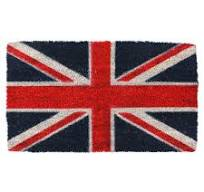

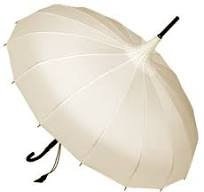

In [ ]:
itemsets_with_two = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x)) == 2]
itemsets_with_two

,support,itemsets
2322,0.037024,"(DOORMAT UNION FLAG, REGENCY CAKESTAND 3 TIER)"
2323,0.024740,"(SCOTTIE DOG HOT WATER BOTTLE, DOORMAT UNION F..."
2324,0.023716,"(CHOCOLATE HOT WATER BOTTLE, DOORMAT UNION FLAG)"
2325,0.023034,"(DOORMAT UNION FLAG, HOT WATER BOTTLE KEEP CALM)"
2326,0.022692,"(DOORMAT UNION FLAG, HOT WATER BOTTLE TEA AND ..."
...,...,...
1308006,0.010749,"(T-LIGHT HOLDER SWEETHEART HANGING, LOVE BUILD..."
1308014,0.010237,"(WHITE HANGING HEART T-LIGHT HOLDER, WHITE HAN..."
1308015,0.011773,"(WHITE HANGING HEART T-LIGHT HOLDER, 12 DAISY ..."
1308016,0.010237,"(PAPER CHAIN KIT 50'S CHRISTMAS , 12 DAISY PEG..."


As you can see most frequently buyed items together are DOORMAT UNION FLAG, REGENCY CAKESTAND 3 TIER, transaction have 0.037 support which is low.

##Antecedents - Consequents confidence levels

### Look confidences Between Two Items - WorldWide

In [ ]:
freq = df.groupby(['Invoice', 'Description'])['Quantity'].sum()
prod_freq = freq.unstack().fillna(0).reset_index().set_index('Invoice')
run_1 = prod_freq.applymap(lambda x: 1 if x > 0 else 0).astype(bool)
frequent_itemsets = fpgrowth(run_1, min_support=0.01, use_colnames=True)

In [ ]:
frequent_itemsets

,support,itemsets
0,0.049591,(STRAWBERRY CERAMIC TRINKET BOX)
1,0.016367,(SAVE THE PLANET MUG)
2,0.013066,(PINK DOUGHNUT TRINKET POT )
3,0.011784,(15CM CHRISTMAS GLASS BALL 20 LIGHTS)
4,0.072340,(ASSORTED COLOUR BIRD ORNAMENT)
...,...,...
722,0.010311,"(LUNCH BAG SPACEBOY DESIGN , LUNCH BAG SUKI DE..."
723,0.011157,"(LUNCH BAG SUKI DESIGN , LUNCH BAG BLACK SKULL.)"
724,0.010611,"(LUNCH BAG APPLE DESIGN, LUNCH BAG RED RETROSPOT)"
725,0.010611,"(SPOTTY BUNTING, PARTY BUNTING)"


In [ ]:
from mlxtend.frequent_patterns import association_rules
association_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
association_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(LOVE BUILDING BLOCK WORD),(HOME BUILDING BLOCK WORD),0.040507,0.049945,0.021440,0.529293,10.597422,0.019417,2.018356,0.943871
1,(PINK BLUE FELT CRAFT TRINKET BOX),(PINK CREAM FELT CRAFT TRINKET BOX ),0.027360,0.033388,0.015548,0.568295,17.020996,0.014635,2.239058,0.967726
2,"(LUNCH BAG CARS BLUE, LUNCH BAG SPACEBOY DESIGN )",(LUNCH BAG BLACK SKULL.),0.019013,0.054474,0.010338,0.543759,9.982075,0.009303,2.072427,0.917260
3,"(LUNCH BAG CARS BLUE, LUNCH BAG BLACK SKULL.)",(LUNCH BAG SPACEBOY DESIGN ),0.020213,0.051118,0.010338,0.511471,10.005617,0.009305,1.942324,0.918624
4,(RED HANGING HEART T-LIGHT HOLDER),(WHITE HANGING HEART T-LIGHT HOLDER),0.044490,0.133333,0.031451,0.706928,5.301962,0.025519,2.957183,0.849170
...,...,...,...,...,...,...,...,...,...,...
100,(POPPY'S PLAYHOUSE BEDROOM ),(POPPY'S PLAYHOUSE LIVINGROOM ),0.015166,0.012548,0.010420,0.687050,54.754926,0.010230,3.155307,0.996856
101,(POPPY'S PLAYHOUSE LIVINGROOM ),(POPPY'S PLAYHOUSE BEDROOM ),0.012548,0.015166,0.010420,0.830435,54.754926,0.010230,5.807993,0.994212
102,(LUNCH BAG SUKI DESIGN ),(LUNCH BAG RED RETROSPOT),0.024523,0.041462,0.012275,0.500556,12.072625,0.011258,1.919211,0.940225
103,(GARDENERS KNEELING PAD CUP OF TEA ),(GARDENERS KNEELING PAD KEEP CALM ),0.017321,0.020622,0.012630,0.729134,35.357205,0.012272,3.615727,0.988845


In [ ]:
filtered_rules = association_rules[~association_rules['consequents'].apply(lambda x: 'POSTAGE' in x)]
filtered_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(LOVE BUILDING BLOCK WORD),(HOME BUILDING BLOCK WORD),0.040507,0.049945,0.021440,0.529293,10.597422,0.019417,2.018356,0.943871
1,(PINK BLUE FELT CRAFT TRINKET BOX),(PINK CREAM FELT CRAFT TRINKET BOX ),0.027360,0.033388,0.015548,0.568295,17.020996,0.014635,2.239058,0.967726
2,"(LUNCH BAG CARS BLUE, LUNCH BAG SPACEBOY DESIGN )",(LUNCH BAG BLACK SKULL.),0.019013,0.054474,0.010338,0.543759,9.982075,0.009303,2.072427,0.917260
3,"(LUNCH BAG CARS BLUE, LUNCH BAG BLACK SKULL.)",(LUNCH BAG SPACEBOY DESIGN ),0.020213,0.051118,0.010338,0.511471,10.005617,0.009305,1.942324,0.918624
4,(RED HANGING HEART T-LIGHT HOLDER),(WHITE HANGING HEART T-LIGHT HOLDER),0.044490,0.133333,0.031451,0.706928,5.301962,0.025519,2.957183,0.849170
...,...,...,...,...,...,...,...,...,...,...
100,(POPPY'S PLAYHOUSE BEDROOM ),(POPPY'S PLAYHOUSE LIVINGROOM ),0.015166,0.012548,0.010420,0.687050,54.754926,0.010230,3.155307,0.996856
101,(POPPY'S PLAYHOUSE LIVINGROOM ),(POPPY'S PLAYHOUSE BEDROOM ),0.012548,0.015166,0.010420,0.830435,54.754926,0.010230,5.807993,0.994212
102,(LUNCH BAG SUKI DESIGN ),(LUNCH BAG RED RETROSPOT),0.024523,0.041462,0.012275,0.500556,12.072625,0.011258,1.919211,0.940225
103,(GARDENERS KNEELING PAD CUP OF TEA ),(GARDENERS KNEELING PAD KEEP CALM ),0.017321,0.020622,0.012630,0.729134,35.357205,0.012272,3.615727,0.988845


In [ ]:
run_3 = filtered_rules[['antecedents', 'consequents', 'confidence']]
run_3 = run_3.sort_values(by='confidence', ascending=False)
run_3

,antecedents,consequents,confidence
65,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.892797
71,"(PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",(GREEN REGENCY TEACUP AND SAUCER),0.887324
99,(POPPY'S PLAYHOUSE LIVINGROOM ),(POPPY'S PLAYHOUSE KITCHEN),0.886957
76,"(PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",(ROSES REGENCY TEACUP AND SAUCER ),0.863850
66,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.852800
...,...,...,...
46,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),0.505925
69,(ROSES REGENCY TEACUP AND SAUCER ),"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",0.504735
35,(BLUE HARMONICA IN BOX ),(RED HARMONICA IN BOX ),0.501840
36,(ROUND SNACK BOXES SET OF 4 FRUITS ),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.501523


In [ ]:
run_3["antecedents"].iloc[0]

frozenset({'PINK REGENCY TEACUP AND SAUCER',
           'ROSES REGENCY TEACUP AND SAUCER '})

1st confidence level products



In [ ]:
run_3.iloc[0]

antecedents    (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...
consequents                    (GREEN REGENCY TEACUP AND SAUCER)
confidence                                              0.892797
Name: 65, dtype: object

2nd confidence level products

In [ ]:
run_3.iloc[1]

antecedents    (PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...
consequents                    (GREEN REGENCY TEACUP AND SAUCER)
confidence                                              0.887324
Name: 71, dtype: object

3rd confidence level products

In [ ]:
run_3.iloc[2]

antecedents    (POPPY'S PLAYHOUSE LIVINGROOM )
consequents        (POPPY'S PLAYHOUSE KITCHEN)
confidence                            0.886957
Name: 99, dtype: object

### France

In [ ]:
country = 'France'
df_country = df[df['Country'] == country]
freq = df_country.groupby(['Invoice', 'Description'])['Quantity'].sum()
prod_freq = freq.unstack().fillna(0).reset_index().set_index('Invoice')

In [ ]:
run_1 = prod_freq.applymap(lambda x: 1 if x > 0 else 0).astype(bool)

total = run_1.shape[0]
run_2 = ("Total numer of transactions for France: ", total)
print(run_2)

('Total numer of transactions for France: ', 594)


In [ ]:
frequent_itemsets = fpgrowth(run_1, min_support=0.08, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.217172,(RED TOADSTOOL LED NIGHT LIGHT)
1,0.087542,(BAKING SET 9 PIECE RETROSPOT )
2,0.087542,(ASSORTED COLOUR MINI CASES)
3,0.101010,(WOODLAND CHARLOTTE BAG)
4,0.087542,(JUMBO BAG WOODLAND ANIMALS)
5,0.094276,(TEA PARTY BIRTHDAY CARD)
6,0.143098,(SET/6 RED SPOTTY PAPER CUPS)
7,0.131313,(SET/6 RED SPOTTY PAPER PLATES)
8,0.122896,(LUNCH BAG WOODLAND)
9,0.181818,(ROUND SNACK BOXES SET OF4 WOODLAND )


In [ ]:
from mlxtend.frequent_patterns import association_rules
association_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
association_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.131313,0.143098,0.119529,0.910256,6.361086,0.100738,9.548341,0.970193
1,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.143098,0.131313,0.119529,0.835294,6.361086,0.100738,5.274170,0.983536
2,(ROUND SNACK BOXES SET OF 4 FRUITS ),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.129630,0.181818,0.080808,0.623377,3.428571,0.057239,2.172414,0.813830
3,(PLASTERS IN TIN CIRCUS PARADE ),(PLASTERS IN TIN WOODLAND ANIMALS),0.175084,0.163300,0.106061,0.605769,3.709556,0.077469,2.122362,0.885455
4,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN CIRCUS PARADE ),0.163300,0.175084,0.106061,0.649485,3.709556,0.077469,2.353436,0.872984
5,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),0.163300,0.132997,0.095960,0.587629,4.418374,0.074241,2.102483,0.924671
6,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.132997,0.163300,0.095960,0.721519,4.418374,0.074241,3.004515,0.892352
7,(PLASTERS IN TIN CIRCUS PARADE ),(PLASTERS IN TIN SPACEBOY),0.175084,0.132997,0.094276,0.538462,4.048685,0.070990,1.878507,0.912828
8,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN CIRCUS PARADE ),0.132997,0.175084,0.094276,0.708861,4.048685,0.070990,2.833407,0.868516
9,(LUNCH BOX WITH CUTLERY RETROSPOT ),(STRAWBERRY LUNCH BOX WITH CUTLERY),0.158249,0.134680,0.085859,0.542553,4.028457,0.064546,1.891629,0.893098


In [ ]:
filtered_rules = association_rules[~association_rules['consequents'].apply(lambda x: 'POSTAGE' in x)]
filtered_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.131313,0.143098,0.119529,0.910256,6.361086,0.100738,9.548341,0.970193
1,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.143098,0.131313,0.119529,0.835294,6.361086,0.100738,5.274170,0.983536
2,(ROUND SNACK BOXES SET OF 4 FRUITS ),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.129630,0.181818,0.080808,0.623377,3.428571,0.057239,2.172414,0.813830
3,(PLASTERS IN TIN CIRCUS PARADE ),(PLASTERS IN TIN WOODLAND ANIMALS),0.175084,0.163300,0.106061,0.605769,3.709556,0.077469,2.122362,0.885455
4,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN CIRCUS PARADE ),0.163300,0.175084,0.106061,0.649485,3.709556,0.077469,2.353436,0.872984
5,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),0.163300,0.132997,0.095960,0.587629,4.418374,0.074241,2.102483,0.924671
6,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.132997,0.163300,0.095960,0.721519,4.418374,0.074241,3.004515,0.892352
7,(PLASTERS IN TIN CIRCUS PARADE ),(PLASTERS IN TIN SPACEBOY),0.175084,0.132997,0.094276,0.538462,4.048685,0.070990,1.878507,0.912828
8,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN CIRCUS PARADE ),0.132997,0.175084,0.094276,0.708861,4.048685,0.070990,2.833407,0.868516
9,(LUNCH BOX WITH CUTLERY RETROSPOT ),(STRAWBERRY LUNCH BOX WITH CUTLERY),0.158249,0.134680,0.085859,0.542553,4.028457,0.064546,1.891629,0.893098


In [ ]:
run_3 = filtered_rules[['antecedents', 'consequents', 'confidence']]
run_3 = run_3.sort_values(by='confidence', ascending=False)
run_3

,antecedents,consequents,confidence
0,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.910256
1,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.835294
6,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.721519
8,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN CIRCUS PARADE ),0.708861
4,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN CIRCUS PARADE ),0.649485
10,(STRAWBERRY LUNCH BOX WITH CUTLERY),(LUNCH BOX WITH CUTLERY RETROSPOT ),0.637500
2,(ROUND SNACK BOXES SET OF 4 FRUITS ),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.623377
3,(PLASTERS IN TIN CIRCUS PARADE ),(PLASTERS IN TIN WOODLAND ANIMALS),0.605769
5,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),0.587629
9,(LUNCH BOX WITH CUTLERY RETROSPOT ),(STRAWBERRY LUNCH BOX WITH CUTLERY),0.542553


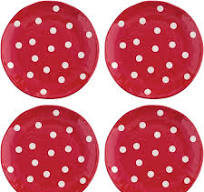

## Germany

In [ ]:
country = 'Germany'
df_country = df[df['Country'] == country]
freq = df_country.groupby(['Invoice', 'Description'])['Quantity'].sum()
prod_freq = freq.unstack().fillna(0).reset_index().set_index('Invoice')

In [ ]:
run_1 = prod_freq.applymap(lambda x: 1 if x > 0 else 0).astype(bool)

total = run_1.shape[0]
run_2 = ("Total numer of transactions for Germany: ", total)
print(run_2)

('Total numer of transactions for Germany: ', 756)


In [ ]:
frequent_itemsets = fpgrowth(run_1, min_support=0.08, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.138889,(RED TOADSTOOL LED NIGHT LIGHT)
1,0.111111,(6 RIBBONS RUSTIC CHARM)
2,0.173280,(WOODLAND CHARLOTTE BAG)
3,0.092593,(WOODLAND PARTY BAG + STICKER SET)
4,0.092593,(WOODLAND DESIGN COTTON TOTE BAG)
5,0.085979,(LUNCH BAG WOODLAND)
6,0.097884,(JUMBO BAG WOODLAND ANIMALS)
7,0.273810,(ROUND SNACK BOXES SET OF4 WOODLAND )
8,0.177249,(ROUND SNACK BOXES SET OF 4 FRUITS )
9,0.082011,(GUMBALL COAT RACK)


In [ ]:
from mlxtend.frequent_patterns import association_rules
association_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
association_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(WOODLAND CHARLOTTE BAG),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.173280,0.273810,0.087302,0.503817,1.840027,0.039856,1.463553,0.552218
1,(ROUND SNACK BOXES SET OF4 WOODLAND ),(ROUND SNACK BOXES SET OF 4 FRUITS ),0.273810,0.177249,0.142857,0.521739,2.943543,0.094325,1.720298,0.909229
2,(ROUND SNACK BOXES SET OF 4 FRUITS ),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.177249,0.273810,0.142857,0.805970,2.943543,0.094325,3.742674,0.802519


In [ ]:
filtered_rules = association_rules[~association_rules['consequents'].apply(lambda x: 'POSTAGE' in x)]
filtered_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(WOODLAND CHARLOTTE BAG),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.173280,0.273810,0.087302,0.503817,1.840027,0.039856,1.463553,0.552218
1,(ROUND SNACK BOXES SET OF4 WOODLAND ),(ROUND SNACK BOXES SET OF 4 FRUITS ),0.273810,0.177249,0.142857,0.521739,2.943543,0.094325,1.720298,0.909229
2,(ROUND SNACK BOXES SET OF 4 FRUITS ),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.177249,0.273810,0.142857,0.805970,2.943543,0.094325,3.742674,0.802519


In [ ]:
run_3 = filtered_rules[['antecedents', 'consequents', 'confidence']]
run_3 = run_3.sort_values(by='confidence', ascending=False)
run_3

,antecedents,consequents,confidence
2,(ROUND SNACK BOXES SET OF 4 FRUITS ),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.805970
1,(ROUND SNACK BOXES SET OF4 WOODLAND ),(ROUND SNACK BOXES SET OF 4 FRUITS ),0.521739
0,(WOODLAND CHARLOTTE BAG),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.503817


you are seeing here most three confidence level transcation from germany. You can see below {ROUND SNACK BOXES SET OF 4 FRUITS} item. As you can see in contrast to England transaction which are mainly England Historical Vintage items, Transaction from germany isn't vintage.

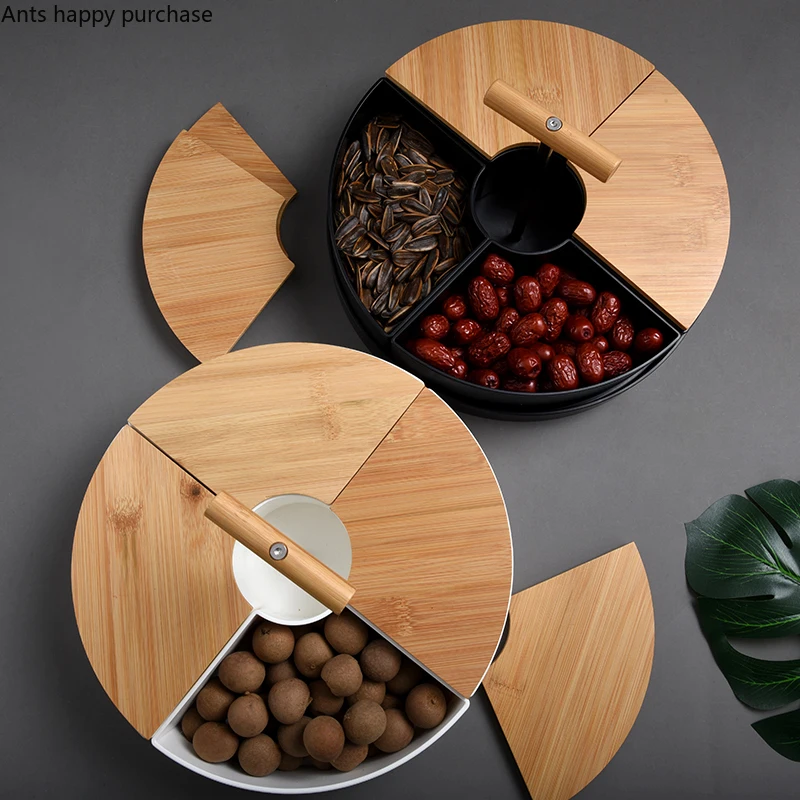

## Rest Of The World

In [ ]:
countries = ['Germany', 'France', 'United Kingdom']
df_country = df[~df['Country'].isin(countries)]
df_country

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,year,month,day,hour,minute,day_of_week,day_name,Monetary,Recency,Customer_ID
175,489450,22087,PAPER BUNTING WHITE LACE,12.0,2009-12-01 10:36:00,2.95,16321.0,Australia,2009,12,1,10,36,1,Tuesday,35.40,759,16321.0
176,489450,85206A,CREAM FELT EASTER EGG BASKET,6.0,2009-12-01 10:36:00,1.65,16321.0,Australia,2009,12,1,10,36,1,Tuesday,9.90,759,16321.0
177,489450,21895,POTTING SHED SOW 'N' GROW SET,4.0,2009-12-01 10:36:00,4.25,16321.0,Australia,2009,12,1,10,36,1,Tuesday,17.00,759,16321.0
178,489450,21896,POTTING SHED TWINE,6.0,2009-12-01 10:36:00,2.10,16321.0,Australia,2009,12,1,10,36,1,Tuesday,12.60,759,16321.0
179,489450,22083,PAPER CHAIN KIT RETRO SPOT,12.0,2009-12-01 10:36:00,2.95,16321.0,Australia,2009,12,1,10,36,1,Tuesday,35.40,759,16321.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801818,581493,20724,RED RETROSPOT CHARLOTTE BAG,10.0,2011-12-09 10:10:00,0.85,12423.0,Belgium,2011,12,9,10,10,4,Friday,8.50,21,12423.0
801819,581493,23204,CHARLOTTE BAG APPLES DESIGN,10.0,2011-12-09 10:10:00,0.85,12423.0,Belgium,2011,12,9,10,10,4,Friday,8.50,21,12423.0
801820,581493,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,18.0,2011-12-09 10:10:00,0.79,12423.0,Belgium,2011,12,9,10,10,4,Friday,14.22,21,12423.0
801821,581493,22252,BIRDCAGE DECORATION TEALIGHT HOLDER,12.0,2011-12-09 10:10:00,1.25,12423.0,Belgium,2011,12,9,10,10,4,Friday,15.00,21,12423.0


In [ ]:
freq = df_country.groupby(['Invoice', 'Description'])['Quantity'].sum()
prod_freq = freq.unstack().fillna(0).reset_index().set_index('Invoice')

In [ ]:
run_1 = prod_freq.applymap(lambda x: 1 if x > 0 else 0).astype(bool)

total = run_1.shape[0]
run_2 = ("Total numer of transactions for Rest of The World: ", total)
print(run_2)

('Total numer of transactions for Rest of The World: ', 1912)


In [ ]:
frequent_itemsets = fpgrowth(run_1, min_support=0.03, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.033473,(SET/3 RED GINGHAM ROSE STORAGE BOX)
1,0.032427,(HOT WATER BOTTLE TEA AND SYMPATHY)
2,0.053870,(PACK OF 72 RETRO SPOT CAKE CASES)
3,0.048640,(STRAWBERRY CERAMIC TRINKET BOX)
4,0.077929,(60 TEATIME FAIRY CAKE CASES)
...,...,...
127,0.040795,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN..."
128,0.033996,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY..."
129,0.033996,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY..."
130,0.030858,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY..."


In [ ]:
from mlxtend.frequent_patterns import association_rules
association_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.05)
association_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(PACK OF 60 PINK PAISLEY CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.068515,0.077929,0.032427,0.473282,6.073262,0.027088,1.750599,0.896787
1,(60 TEATIME FAIRY CAKE CASES),(PACK OF 60 PINK PAISLEY CAKE CASES),0.077929,0.068515,0.032427,0.416107,6.073262,0.027088,1.595303,0.905943
2,(ROUND SNACK BOXES SET OF4 WOODLAND ),(ROUND SNACK BOXES SET OF 4 FRUITS ),0.099372,0.060146,0.041841,0.421053,7.000458,0.035864,1.623383,0.951728
3,(ROUND SNACK BOXES SET OF 4 FRUITS ),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.060146,0.099372,0.041841,0.695652,7.000458,0.035864,2.959205,0.912006
4,(PLASTERS IN TIN CIRCUS PARADE ),(PLASTERS IN TIN SPACEBOY),0.076360,0.072699,0.035042,0.458904,6.312408,0.029491,1.713747,0.911158
5,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN CIRCUS PARADE ),0.072699,0.076360,0.035042,0.482014,6.312408,0.029491,1.783139,0.907560
6,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),0.074268,0.072699,0.041841,0.563380,7.749519,0.036442,2.123819,0.940833
7,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.072699,0.074268,0.041841,0.575540,7.749519,0.036442,2.180962,0.939241
8,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN CIRCUS PARADE ),0.074268,0.076360,0.036611,0.492958,6.455721,0.030940,1.821624,0.912897
9,(PLASTERS IN TIN CIRCUS PARADE ),(PLASTERS IN TIN WOODLAND ANIMALS),0.076360,0.074268,0.036611,0.479452,6.455721,0.030940,1.778380,0.914965


In [ ]:
filtered_rules = association_rules[~association_rules['consequents'].apply(lambda x: 'POSTAGE' in x)]
filtered_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(PACK OF 60 PINK PAISLEY CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.068515,0.077929,0.032427,0.473282,6.073262,0.027088,1.750599,0.896787
1,(60 TEATIME FAIRY CAKE CASES),(PACK OF 60 PINK PAISLEY CAKE CASES),0.077929,0.068515,0.032427,0.416107,6.073262,0.027088,1.595303,0.905943
2,(ROUND SNACK BOXES SET OF4 WOODLAND ),(ROUND SNACK BOXES SET OF 4 FRUITS ),0.099372,0.060146,0.041841,0.421053,7.000458,0.035864,1.623383,0.951728
3,(ROUND SNACK BOXES SET OF 4 FRUITS ),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.060146,0.099372,0.041841,0.695652,7.000458,0.035864,2.959205,0.912006
4,(PLASTERS IN TIN CIRCUS PARADE ),(PLASTERS IN TIN SPACEBOY),0.076360,0.072699,0.035042,0.458904,6.312408,0.029491,1.713747,0.911158
5,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN CIRCUS PARADE ),0.072699,0.076360,0.035042,0.482014,6.312408,0.029491,1.783139,0.907560
6,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),0.074268,0.072699,0.041841,0.563380,7.749519,0.036442,2.123819,0.940833
7,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.072699,0.074268,0.041841,0.575540,7.749519,0.036442,2.180962,0.939241
8,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN CIRCUS PARADE ),0.074268,0.076360,0.036611,0.492958,6.455721,0.030940,1.821624,0.912897
9,(PLASTERS IN TIN CIRCUS PARADE ),(PLASTERS IN TIN WOODLAND ANIMALS),0.076360,0.074268,0.036611,0.479452,6.455721,0.030940,1.778380,0.914965


In [ ]:
run_3 = filtered_rules[['antecedents', 'consequents', 'confidence']]
run_3 = run_3.sort_values(by='confidence', ascending=False)
run_3

,antecedents,consequents,confidence
29,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.907692
28,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.907692
26,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.878378
24,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.878378
23,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.857143
31,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.797297
17,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX ),0.776398
16,(SPACEBOY LUNCH BOX ),(DOLLY GIRL LUNCH BOX),0.762195
30,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",(PINK REGENCY TEACUP AND SAUCER),0.756410
25,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.714286


As you can see here {PINK REGENCY TEACUP AND SAUCER} and {GREEN REGENCY TEACUP AND SAUCER} have strong confidence with  {ROSES REGENCY TEACUP AND SAUCER}. This indiates that likelihood of antecedents items and consequents item transcations. This correlation is expected because this are England vintage and our transcation from mainly England.

## Conclusion

Through our project we conducted many datamining experiment experiment and tried to extract meaningful relationship on our 1 million transcation dataset. For this propose we used FP-Growth and Apriori algorithms. We run these algorithms over 4 different country part which are England, France, Germany and Rest of the world. On UK dataset we find high correlation between English Historical vintahe items. On Germany transcation there wasn't much highly correlated transcation because of small size of dataset but there was high correlation between diffent purposed boxes. On France dataset there was more correlation than germany transcation this could be because of france transaction have second most transcation country. France have strong condifence level between red coulored plates and cups.